# Solving the Shallow Water Equations using Finite Volumes and Lax-Friedrichs
---
Nathan Brei

Technical University of Munich

14 December 2017

---

This paper has three aims:
- Briefly introduce shallow water equations
- Explore the concept of numerical viscosity via Lax-Friedrich and Local-Lax-Friedrich methods
- Demonstrate code organization using Julia

# Shallow Water Equations (1-D)

The shallow water equations are a set of hyperbolic partial differential equations.

Specifically, they describe mass and momentum conservation on a fluid in a channel of unit width, subject to the following assumptions:

* Small vertical velocity
* Pressure is determined by hydrostatic pressure $p=\frac{1}{2}\rho gh^2$
* Constant horizontal velocity $u(x)$ across any cross section $x$

$\begin{bmatrix}h \\ hu \end{bmatrix}_t + \begin{bmatrix}hu \\ hu^2 + \frac{1}{2}gh^2\end{bmatrix}_x = 0 $


Formulate as a general conservation law in differential form: $q_t(x,t) + f(q(x,t))_x = 0$

$q := (h, hu) \in Q$

$f : (q_1, q_2) \mapsto \begin{bmatrix} q_2\\ q_2^2/q_1 + \frac{1}{2}gq_1^2\end{bmatrix}$

How do we abstract this?
- Need state space, flux, and wavespeed

The first step to translating this into Julia is to use 

In [6]:
const Float = Float64
const G = 9.81f0

mutable struct Q
    h :: Float
    hu :: Float
end

QS = Array{Q,1}

Array{Q,1}

In [4]:
function f(q :: Q)
    Q(q.hu, q.hu^2/q.h + 0.5*G*q.h^2)
end

LoadError: [91mUndefVarError: Q not defined[39m



## Types and Methods in Julia

* Types are composed of primitives, structures, unions, tuples, abstract types
* Types are parametric
* Type annotations are optional
* Inheritance is restricted to abstract types
* Type system offers no encapsulation, but does support invariants and immutability
* Methods resolved via multiple dispatch (using all arguments rather than the first)

## Defining a vector space over Q

In [217]:
import Base.+
import Base.-
import Base.*

function +(lhs::Q, rhs::Q)
    Q(lhs.h + rhs.h, lhs.hu + rhs.hu)
end

function -(lhs::Q, rhs::Q)
    Q(lhs.h - rhs.h, lhs.hu - rhs.hu)
end

function *(a::Real, q::Q)
    Q(a*q.h, a*q.hu)
end

* (generic function with 215 methods)

The third place where the shallow water equations enter the numerical model is in the wavespeed function. The physical wave speeds are given by the eigenvalues of the flux Jacobian

$f'(q) = \begin{bmatrix}0 & 1 \\ -u^2 + gh & 2u \end{bmatrix}$

$\lambda_{max} = \max\ \lvert u \pm \sqrt{gh} \rvert$

- What does the wavespeed represent physically?
These 


In [2]:
function wavespeed(q :: Q)
    u = q.hu / q.h
    c = sqrt(G * q.h)
    max(abs(u-c), abs(u+c))
end

LoadError: [91mUndefVarError: Q not defined[39m


What is the CFL condition?

* Necessary condition for numerical stability
* Information propagates through the spatial domain at finite speeds
* Need {true domain of dependence} $\subset$ {numerical domain of dependence}

- Intuitive meaning: Outrunning
- Why is there a correction term? Linear vs nonlinear case

$ \nu := \lvert\frac{\bar{u}\Delta t}{\Delta x} \rvert = \frac{\Delta t}{\Delta x} \lvert \lambda_{max} \rvert  \leq 1 $



In [3]:

function cfl_dt(qs::Array{Q,1}, dx::Float, correction=1.0::Float)
    lambda = map(wavespeed,qs) |> maximum
    dx / lambda * correction
end

LoadError: [91mUndefVarError: Q not defined[39m

## Finite Volumes

- What are finite volumes? 
- Advantages: Conserves physical quantities

Let $C_i := (x_{i-1/2}, x_{i+1/2})$ represent a grid cell in our spatial domain. The conservation equations may be represented in integral form as:

$$\frac{d}{dt} \int_{C_i} q(x,t) dx = f(q(x_{i-1/2},t)) - f(q(x_{1+1/2},t))$$

- Define spatial domain in Julia
-- Ghost cells, indexing, type aliasing

Integrate both sides with respect to time:

$$\int_{C_i} q(x,t_{n+1})dx - \int_{C_i} q(x,t_n) dx = \int_{t_n}^{t_{n+1}} f(q(x_{i-1/2},t))dt - \int_{t_n}^{t_{n+1}} f(q(x_{i+1/2},t))dt $$

Let $Q_{i}^{n} \approx \frac{1}{\Delta x} \int_{C_i} q(x,t_n) dx $ be the appx. average $q$ in cell $i$ at time $n$.

Let $F_{i+1/2}^{n} \approx \frac{1}{\Delta t} \int_{t_n}^{t_{n+1}} f(q(x_{i+1/2},t))dt$ be the appx. average flux $f$ from cell $i$ into $i+1$.

Rearranging, we get a general update scheme

$Q_{i}^{n+1} = Q_{i}^{n} - \frac{\Delta t}{\Delta x}(F_{i+1/2}^{n} - F_{i-1/2}^{n}) $

In [219]:
function update_qs!(qs::QS, Fl::QS, Fr::QS, ncells::Int,
                    dx::Float, dt::Float)
    
    for x = 2:ncells+1
        qs[x] -= dt/dx * (Fr[x] + Fl[x-1])
    end
end

update_qs! (generic function with 1 method)

| Math              | Code        | Description |
|----------------   |-------------|-------------|
|  $Q_{i}^{n}$      | ```qs[x]``` | 1D array of Q containing solution states
|  $F_{i+1/2}^{n}$  | ```Fr[x]``` | 1D array of Q containing flux flowing right 
|  $F_{i-1/2}^{n}$  | ```Fl[x]``` | 1D array of Q containing flux flowing left

* Each buffer is of length ```ncells+2```, accounting for ghost cells at either end
* Functions suffixed with a ! update one or more of their buffers in-place

# Timestepping loop

In [41]:
function run_experiment(stoptime, ncells::Int, choose_dt,
                        compute_fluxes!, apply_bcs!, apply_ics)

    qs = apply_ics(ncells)
    Fl = QS(ncells+2)
    Fr = QS(ncells+2)

    currenttime = 0
    timesteps = 0
    dx = Float(1000.0/ncells)
    
    while currenttime < stoptime
        apply_bcs!(qs)
        dt = choose_dt(qs, dx)
        compute_fluxes!(qs, Fl, Fr, ncells, dx, dt)
        update_qs!(qs, Fl, Fr, ncells, dx, dt)
        currenttime += dt
        timesteps += 1
    end
    return (qs, currenttime, timesteps)
end

run_experiment (generic function with 1 method)

# Timestepping loop for animations
* Outer timesteps correspond to clean increments of physical time
* An outer loop controls outer timesteps by iterating over stoptime
* Inner timesteps correspond to increments of dt
* Inner timesteps go up to stop time exactly

In [113]:
function run_experiment!(qs, Fl, Fr, 
                         currenttime::Real, stoptime::Real, 
                         ncells::Int, 
                         choose_dt, compute_fluxes!, apply_bcs!)

    timesteps = 0
    dx = Float(1000.0/ncells)
    
    while currenttime < stoptime
        apply_bcs!(qs)
        dt = choose_dt(qs, dx)
        if currenttime + dt > stoptime
            dt = stoptime - currenttime
        end
        compute_fluxes!(qs, Fl, Fr, ncells, dx, dt)
        update_qs!(qs, Fl, Fr, ncells, dx, dt)
        currenttime += dt
        timesteps += 1
    end
    return (qs, currenttime, timesteps)
end

run_experiment! (generic function with 2 methods)

# Lax-Friedrichs by accident

Consider the simplest choice of F: 

$ F_{i-1/2} = \frac{1}{2}[f(Q_{i-1} + f(Q_i)] $

$ Q_i^{n+1} = Q_i^n - \frac{\Delta t}{2 \Delta x} [f(Q_{i+1}^n) - f(Q_{i-1}^n)]$

Unfortunately this is unstable. 

Instead, replace $Q_i^n$ with $\frac{1}{2}(Q_{i-1}^n + Q_{i+1}^n)$

$ Q_i^{n+1} = \frac{1}{2}(Q_{i-1}^n + Q_{i+1}^n) - \frac{\Delta t}{2 \Delta x} [f(Q_{i+1}^n) - f(Q_{i-1}^n)]$

Rearrange to get a flux update function:

$ F_{i-1/2} = \frac{1}{2} [ f(Q_{i-1}) + f(Q_i) - a(Q_i - Q_{i-1})]$ 


# Lax-Friedrichs Solver
* Input:  Buffers for $q(x), F_l(x), F_r(x)$, cell and timestep sizes
* Output: Updated inter-cell flux buffers


In [40]:
function lxf!(qs::QS, Fl::QS, Fr::QS, ncells::Int, 
              dx::Float, dt::Float)
    
    a = dx/dt
    
    for x = 2:ncells+2

        ql = qs[x-1]
        qr = qs[x]
        fl = f(ql)
        fr = f(qr)        

        Fr[x-1] = 0.5*((fr - fl) - a*(qr - ql))
        Fl[x-1] = 0.5*((fr - fl) + a*(qr - ql))
    end
end

lxf! (generic function with 1 method)

In [8]:
# Set up plotting infrastructure
using Plots
pyplot()

function plotxh(qs, title)
    xs = linspace(0,1,length(qs))
    hs = map(q->q.h, qs)
    plot(xs, hs, title=title, xlabel="x [m]", ylabel="height [m]", ylim=(0.,2.5), legend=false)
end

function plotxhul(qs, title)
    p0 = plot(map(q->q.h, qs), xlabel="x [m]", ylabel="height [m]", title=title)
    p1 = plot(map(q->q.hu, qs), xlabel="x [m]", ylabel="hu")
    p2 = plot(map(wavespeed, qs), xlabel="x [m]", ylabel="\$\\lambda_{max}\$ [m/s]")
    plot(p0,p1,p2,layout=(3,1),legend=false)
end

function plotxhs(qss, labels, title)
    p = plot(title=title, xlabel="x [m]", ylabel="height [m]", ylim=(0.,2.5))
    for i=1:length(qss)
        x = linspace(0,1,length(qss[i])-2)
        plot!(x, map(q->q.h, qss[i]), label=labels[i])
    end
    p
end

function plotxh(title)
    plot(title=title, xlabel="x [m]", ylabel="height [m]", ylim=(0.,2.5))
end

function plotxh!(p, qs, label)
    xs = linspace(0,1,length(qs))
    hs = map(q->q.h, qs)
    plot!(p, xs, hs, label=label)
end
    


plotxh! (generic function with 1 method)

# Gaussian Initial Condition

In [7]:
function gaussian_ics(ncells::Int)
    qs = QS(ncells+2)
    mid = ncells / 2.0 + 1
    for x = 1:ncells+2
        pos_rel = (mid-x) / (ncells/10.0)
        qs[x] = Q(exp(-pos_rel^2) + 1, 0.0)
    end
    return qs
end
plotxh(gaussian_ics(100), "Gaussian initial conditions")

LoadError: [91mUndefVarError: plotxh not defined[39m

# Breaking Dam Initial Conditions


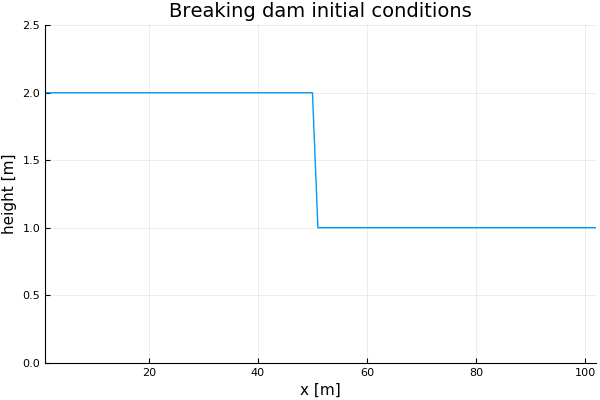

In [107]:
function breakingdam_ics(ncells::Int)
    [x < ncells/2+1 ? Q(2,0) : Q(1,0) for x in 1:ncells+2]
end

plotxh(breakingdam_ics(100), "Breaking dam initial conditions")

# Boundary Conditions

In [176]:

function outflow_bcs!(qs::QS)
    qs[1] = qs[2]
    qs[end] = qs[end-1]
end

function periodic_bcs!(qs::QS)
    qs[1] = qs[end-1]
    qs[end] = qs[2]
end

function reflecting_bcs!(qs::QS)
    qs[1].h = qs[2].h
    qs[1].hu = -qs[2].hu
    qs[end].h = qs[end-1].h
    qs[end].hu = -qs[end-1].hu
end

reflecting_bcs! (generic function with 1 method)

# Timestep strategies

* Idea: Strategies are simply functions
* Timestep strategy always has the signature $ ([q], \Delta x) \mapsto \Delta t $
* Use _currying_ to pass configuration information
* Use _closures_ to hold any state that may change at runtime 

In [221]:
function make_const_dt(dt)
    return (qs, dx) -> dt
end

function make_cfl_dt(correction::Float)
    return (qs, dx) -> cfl_dt(qs, dx, correction)
end

function make_lagging_dt(dt0, correction)
    dt = dt0
    function lagging_dt(qs, dx)
        result = dt
        dt = cfl_dt(qs, dx, correction)
        return result
    end
    return lagging_dt
end

make_lagging_dt (generic function with 1 method)

# Lax-Friedrichs solutions

In [198]:
ncells = 500
t0 = 0
qs = breakingdam_ics(ncells)
Fl = QS(ncells+2)
Fr = QS(ncells+2)
a = @animate for t=0.0:4.0:2000.0
    qs,t0,ts = run_experiment!(qs, Fl, Fr, t0, t, ncells, make_cfl_dt(1.0), lxf!, reflecting_bcs!)
    plotxh(qs, "Lax-Friedrichs, breaking dam, reflecting boundaries, t=$t")
end
figure24 = gif(a, "animations/breakingdam_lxf_reflecting.gif", fps = 20);

INFO: Saved animation to /Users/nathanwbrei/src/shallow_water/animations/breakingdam_lxf_reflecting.gif


In [199]:
figure24

Plots.AnimatedGif("/Users/nathanwbrei/src/shallow_water/animations/breakingdam_lxf_reflecting.gif")

* Breaking dam scenario with reflecting boundary conditions, $t=0..2000, ncells=500, x=1.0$


# Lax-Friedrichs solutions

In [194]:
ncells = 100
t0 = 0
qs = gaussian_ics(ncells)
Fl = QS(ncells+2)
Fr = QS(ncells+2)
a = @animate for t=0:4:800
    qs,t0,ts = run_experiment!(qs, Fl, Fr, t0, t, ncells, make_cfl_dt(1.0), lxf!, periodic_bcs!)
    plotxh(qs, "Lax-Friedrichs, gaussian, periodic boundaries, t=$t")
end
anim22 = a

Plots.Animation("/var/folders/1k/q68xhskx4ks0dfs38lkh72y40000gn/T/tmpJuhzNT", String["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000192.png", "000193.png", "000194.png", "000195.png", "000196.png", "000197.png", "000198.png", "000199.png", "000200.png", "000201.png"])

In [195]:
figure22 = gif(anim22, "animations/gauss_lxf.gif", fps = 20);

INFO: Saved animation to /Users/nathanwbrei/src/shallow_water/animations/gauss_lxf.gif


In [196]:
figure22

Plots.AnimatedGif("/Users/nathanwbrei/src/shallow_water/animations/gauss_lxf.gif")

* Gaussian scenario with periodic boundaries, $t=800, ncells=100, w=1.0$

# Effect of timestep correction term


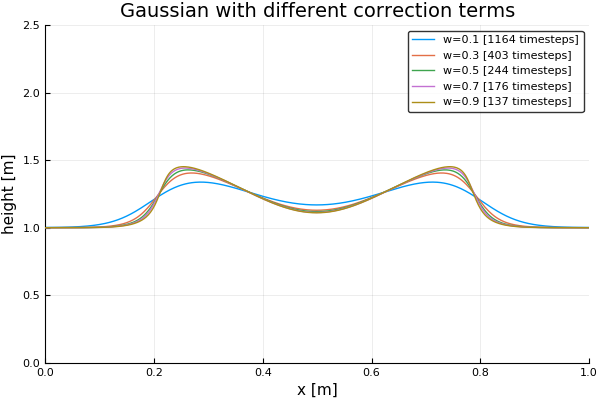

In [213]:
p = plotxh("Gaussian with different correction terms")
for w = [0.1, 0.3, 0.5, 0.7, 0.9]
    qs,t,ts = run_experiment(50, 500, make_cfl_dt(w), lxf!, periodic_bcs!, gaussian_ics)
    plotxh!(p, qs, "w=$w [$ts timesteps]")
end
display(p)

# Effect of timestep correction term


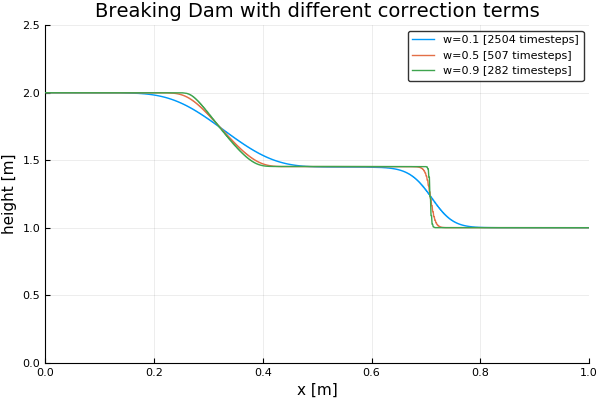

In [212]:
p = plotxh("Breaking Dam with different correction terms")
for w = [0.1, 0.5, 0.9]
    qs,t,ts = run_experiment(50, 1000, make_cfl_dt(w), lxf!, outflow_bcs!, breakingdam_ics)
    plotxh!(p, qs, "w=$w [$ts timesteps]")
end
display(p)

# Artificial Viscosity

Idea: An approximate solution is often an exact solution to an approximate problem. 

Consider $q_t + {f_{SWE}(q)}_x = 0 \implies F_{i+1/2} = 1/2 (f_{SWE}(Q_{i+1/2} + f_{SWE}(Q_{i-1/2})) $

Consider $q_t = \beta q_{xx} \implies F_{i+1/2} = -\frac{\Delta x^2}{2 \Delta t} \frac{Q_{i+1/2} - Q_{i-1/2}}{\Delta x}$

Our Lax-Friedrichs solver looks like:

$ F_{i-1/2} = \frac{1}{2} [f(Q_{i-1}) + f(Q_i)] - \frac{\Delta x}{2\Delta t}[Q_i - Q_{i-1}]$ 

Which can be decomposed to:

$ q_t + f_{SWE}(q)_x = \frac{(\Delta x)^2}{2\Delta t} q_{xx} $

Apparent viscosity $\beta = \frac{(\Delta x)^2}{2\Delta t} = \frac{a \Delta x}{2}$

Consistency: $\beta \to 0$ if $a = \frac{\Delta x}{\Delta t}$ is held constant as $\Delta x \to 0$ 


# Local Lax-Friedrichs / Rusanov Improvement

For Lax-Friedrichs, the viscosity $a$ is constant over the whole domain

* Idea: Viscosity should vary over spatial domain

* Idea: Only need to smooth areas with high wave speeds

Let $a_{i-1/2} = max(\lvert f'(q) \rvert) \ \forall q \in (Q_{i-1}, Q_{i})$

Then $ F_{i-1/2} = \frac{1}{2}[f(Q_{i-1}) + f(Q_i) - a_{i-1/2}(Q_i - Q_{i-1})]$

* This is strictly less viscous than ordinary LxF due to CFL:

$\lvert f'(q)\rvert \leq \frac{\Delta x}{\Delta t}$




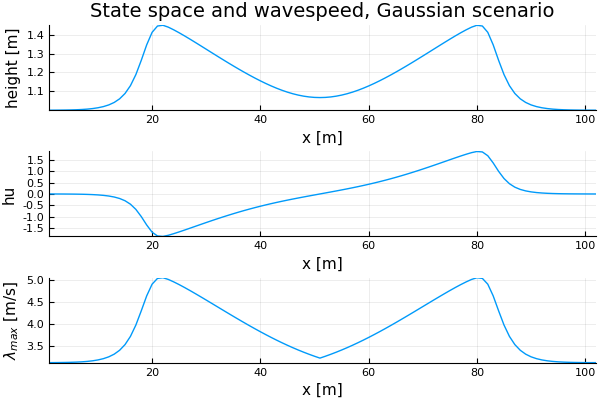

In [229]:
qs,t,ts = run_experiment(60, 100, cfl_dt, lxf!, periodic_bcs!, gaussian_ics)
plotxhul(qs, "State space and wavespeed, Gaussian scenario")

# Local Lax Friedrichs (Rusanov) Implementation

In [45]:
function llxf!(qs::QS, Fl::QS, Fr::QS, ncells::Int, 
               dx::Float, dt::Float)
    
    for x = 2:ncells+2

        ql = qs[x-1]
        qr = qs[x]
        fl = f(ql)
        fr = f(qr)  

        a = max(wavespeed(ql), wavespeed(qr))
        
        Fr[x-1] = 0.5*((fr - fl) - a*(qr - ql))
        Fl[x-1] = 0.5*((fr - fl) + a*(qr - ql))
    end
end

llxf! (generic function with 1 method)

# Comparing Lax-Friedrich to Local-Lax-Friedrich

In [91]:
q1,t,ts = run_experiment(50, 500, make_cfl_dt(0.3), llxf!, outflow_bcs!, breakingdam_ics)
q2,t,ts = run_experiment(50, 500, make_cfl_dt(0.3), lxf!, outflow_bcs!, breakingdam_ics)
p = plotxh("Breaking Dam using LxF vs Local-LxF")
plotxh!(p, q1, "LLxF [$ts timesteps]")
plotxh!(p, q2, "LxF [$ts timesteps]")
figure1 = p;

In [226]:
ncells = 200

t0 = 0
qs = breakingdam_ics(ncells)
Fl = Array{Q,1}(ncells+2)
Fr = Array{Q,1}(ncells+2)

t0l = 0
qsl = breakingdam_ics(ncells)
Fll = Array{Q,1}(ncells+2)
Frl = Array{Q,1}(ncells+2)

a = @animate for t=0.0:4.0:1000.0
    p = plotxh("Breaking dam, reflecting boundaries, t=$t")
    q,t0,ts = run_experiment!(qs, Fl, Fr, t0, t, ncells, make_cfl_dt(0.4), lxf!, reflecting_bcs!)
    ql,t0l,tsl = run_experiment!(qsl, Fll, Frl, t0l, t, ncells, make_cfl_dt(0.4), llxf!, reflecting_bcs!)
    plotxh!(p, q, "LxF w=0.4, timesteps=$ts")
    plotxh!(p, ql, "LLxF w=0.4, timesteps=$tsl")
end
figure31 = gif(a, "animations/breakingdam_reflecting_cmp.gif", fps = 20);

INFO: Saved animation to /Users/nathanwbrei/src/shallow_water/animations/breakingdam_reflecting_cmp.gif


In [208]:
figure31

Plots.AnimatedGif("/Users/nathanwbrei/src/shallow_water/animations/breakingdam_reflecting_cmp.gif")

* Run breaking dam scenario with $t=0..1000, ncells=200, correction=0.4$
* Both waves propagate at the same speed, no apparent loss of conserved quantities
* Local-Lax-Friedrich dissipates less than Lax-Friedrich for the same correction factor
* Local-Lax-Friedrich is smooth, whereas Lax-Friedrich exhibits stairstepping

# Comparing Lax-Friedrich to Local-Lax-Friedrich

In [153]:
p = plotxh("Breaking Dam comparison of LxF vs Local-LxF")
for w = [0.1, 0.4, 0.9]
    qs,t,ts = run_experiment(50, 200, make_cfl_dt(w), llxf!, outflow_bcs!, breakingdam_ics)
    plotxh!(p, qs, "LLxF w=$w [$ts timesteps]")
end
qs,t,ts = run_experiment(50, 200, make_cfl_dt(1.0), lxf!, outflow_bcs!, breakingdam_ics)
plotxh!(p, qs, "LxF w=1.0 [$ts timesteps]")
figure2 = p;


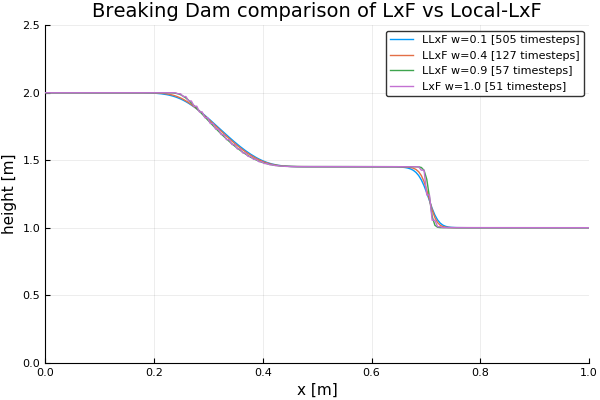

In [154]:
figure2

In [209]:
a = @animate for w = 0.1:0.1:1.0
    qll,t,tsl = run_experiment(50, 200, make_cfl_dt(w), llxf!, outflow_bcs!, breakingdam_ics)
    ql,t,ts   = run_experiment(50, 200, make_cfl_dt(w), lxf!, outflow_bcs!, breakingdam_ics)
    p = plotxh("Breaking Dam comparison of LxF vs Local-LxF")
    plotxh!(p, qll, "LLxF w=$w")
    plotxh!(p, ql, "LxF w=$w")
end
llxf_w_lt_1 = a;

In [210]:
figure3 = gif(llxf_w_lt_1, "animations/llxf_w_lt_1.gif", fps = 10);

INFO: Saved animation to /Users/nathanwbrei/src/shallow_water/animations/llxf_w_lt_1.gif


In [211]:
figure3

Plots.AnimatedGif("/Users/nathanwbrei/src/shallow_water/animations/llxf_w_lt_1.gif")

* For Lax-Friedrich, $w$ affects dissipation
* For Local-Lax-Friedrich, $w$ affects dissipation much less
* Lax-Friedrich approaches Local-Lax-Friedrich as $w \to 1.0$
* Both methods are unstable for $w > 1.0$ due to CFL violation

# Comparing Lax-Friedrich to Local-Lax-Friedrich

In [215]:
ncells = 200

t0 = 0
qs = gaussian_ics(ncells)
Fl = Array{Q,1}(ncells+2)
Fr = Array{Q,1}(ncells+2)

t0l = 0
qsl = gaussian_ics(ncells)
Fll = Array{Q,1}(ncells+2)
Frl = Array{Q,1}(ncells+2)

a = @animate for t=0.0:4.0:1000.0
    p = plotxh("Gaussian, periodic boundaries, t=$t")
    q,t0,ts = run_experiment!(qs, Fl, Fr, t0, t, ncells, make_cfl_dt(0.4), lxf!, periodic_bcs!)
    ql,t0l,tsl = run_experiment!(qsl, Fll, Frl, t0l, t, ncells, make_cfl_dt(0.4), llxf!, periodic_bcs!)
    plotxh!(p, q, "LxF w=0.4, timesteps=$ts")
    plotxh!(p, ql, "LLxF w=0.4, timesteps=$tsl")
end
figure32 = gif(a, "animations/gaussian_cmp.gif", fps = 20);

INFO: Saved animation to /Users/nathanwbrei/src/shallow_water/animations/gaussian_cmp.gif


In [216]:
figure31

Plots.AnimatedGif("/Users/nathanwbrei/src/shallow_water/animations/gaussian_cmp.gif")

* Run gaussian scenario with $t=0..1000, ncells=200, correction=0.4$

# Implementation Details -- Spatial Discretization

In [ ]:
p = plotxh("Gaussian for different ncells")
for ncells = [100,200,300,400,500,600]
    qs,t,ts = run_experiment(2000, ncells, 1.0, periodic_bcs!, gaussian_ics)
    plotxh!(p, qs, "ncells=$ncells [$ts timesteps]")
end
display(p)

# Implementation Details -- Staircase instability from incorrect dt

* The existing code skeleton does not use the $\Delta t$ obtained from the CFL condition inside Lax-Friedrichs
* Instead, it uses the $\Delta t$ from the previous timestep
* The initial value $\Delta t_0 = 0.4\frac{ncells}{a_{adv}}$ where $a_{adv} = 0.25$
* This leads to a staircase instability:

In [ ]:
q1,t,ts1 = run_experiment(800, 200, make_cfl_dt(0.4), lxf!, outflow_bcs!, breakingdam_ics)
q2,t,ts2 = run_experiment(800, 200, make_lagging_dt(0.4), outflow_bcs!, breakingdam_ics)

p = plotxh("Breaking Dam comparison of LxF vs LxF-staircase")
plotxh!(p, q1, "LLxF w=0.7 [$ts1 timesteps]")
plotxh!(p, q2, "LLxF_staircase w=0.7 [$ts2 timesteps]")
display(p)


# Thank you!

---
